# TIME SERIES FORECASTING USING ARIMA MODEL

In [43]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

In [45]:
from google.colab import files
uploaded = files.upload()

Saving AirPassengers.csv to AirPassengers (1).csv


In [78]:
df_orig = pd.read_csv('AirPassengers (1).csv')
df_orig.rename(columns={'#Passengers': 'Passengers'}, inplace =True)
df_orig['Passengers'] = df_orig['Passengers'].astype(int)
df_orig['Month'] = pd.to_datetime(df_orig['Month'], infer_datetime_format=True)
df = df_orig.copy()
df = df.set_index(['Month'])
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


# **Checking if the dataset is Stationary**

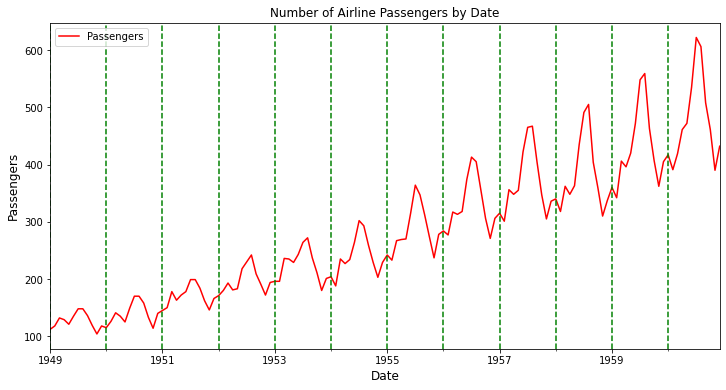

In [79]:
df_orig.plot(x='Month', y='Passengers', figsize=(12,6), color='red')
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Passengers', fontsize=12)
for i in range(12):
    plt.axvline(x=f'{str(1949+i)}-01-01', color='green', linestyle='--')
plt.show()


# **Rolling Statistics**

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

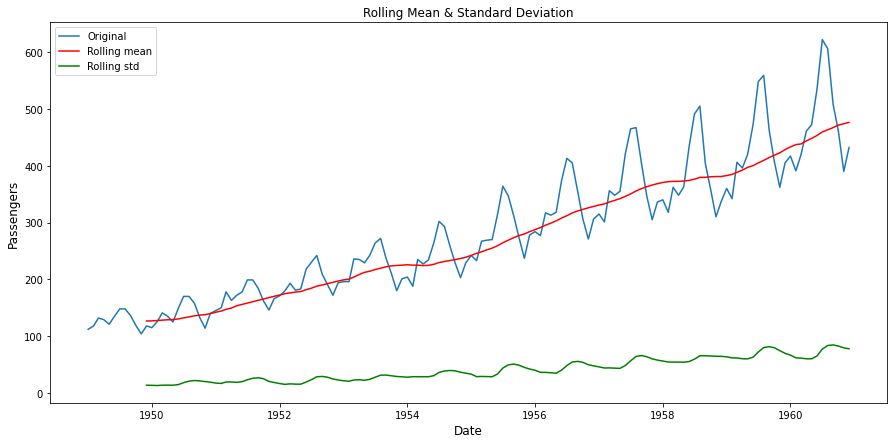

In [80]:
plt.figure(figsize=(15,7))
plt.plot(df["Passengers"], label='Original')
plt.plot(df["Passengers"].rolling(window=12).mean(), color='red', label='Rolling mean')
plt.plot(df["Passengers"].rolling(window=12).std(), color='green', label='Rolling std')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Passengers', fontsize=12)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

# Augmented Dickey–Fuller Test

In [81]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [82]:
ADF_test(df)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
Lags Used                       13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


# **Seasonal decompose**



In [83]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', extrapolate_trend=12)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 10)
    plt.show()
    
    return trend, seasonal, residual

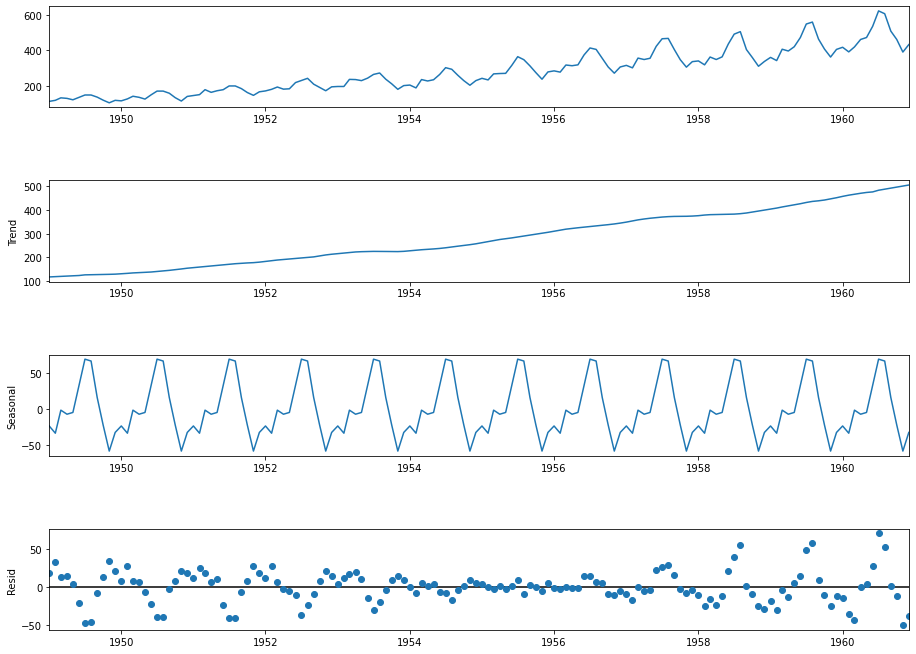

In [84]:
trend, seasonal, residual = seasonal_decompose(df)

# **Splitting the data into Train and test**

In [85]:
train_data = df[:int(len(df)*0.8)]
test_data = df[int(len(df)*0.8):]

# **Finding the value of the d parameter**

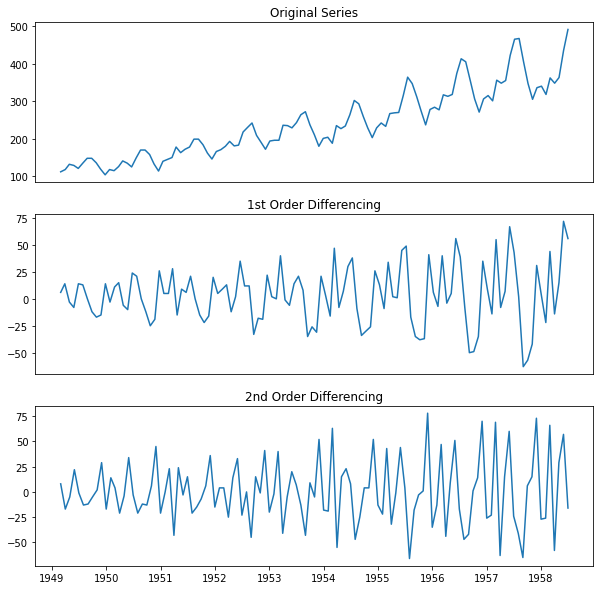

In [86]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 10))
ax1.plot(train_data.Passengers)
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(train_data.Passengers.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(train_data.Passengers.diff().diff())
ax3.set_title('2nd Order Differencing')
plt.show()

Text(0.5, 1.0, 'Autocorrelation for second-order differencing')

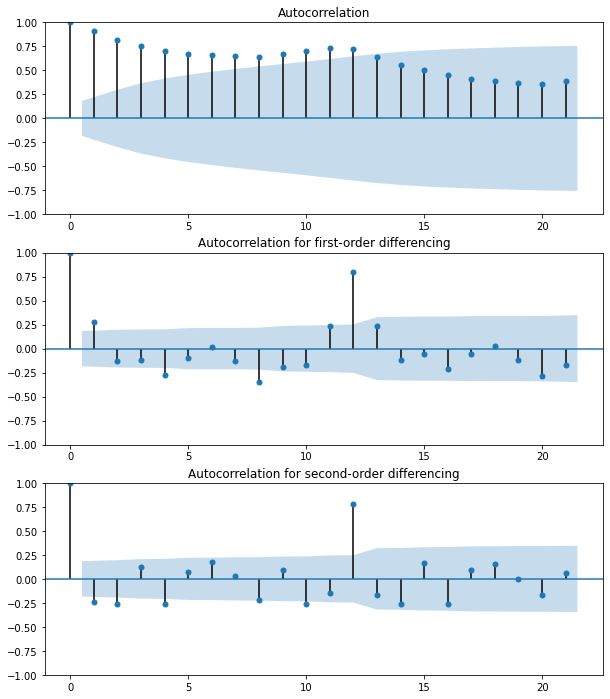

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
_ = plot_acf(train_data.Passengers, ax=ax1)
_ = plot_acf(train_data.Passengers.diff().dropna(), ax=ax2)
ax2.set_title('Autocorrelation for first-order differencing')
_ = plot_acf(train_data.Passengers.diff().diff().dropna(), ax=ax3)
ax3.set_title('Autocorrelation for second-order differencing')

# **Finding the value of the p parameter**

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


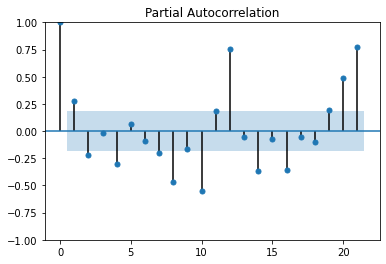

In [88]:
_ = plot_pacf(train_data.Passengers.diff().dropna())

# **Finding the value of the q parameter**

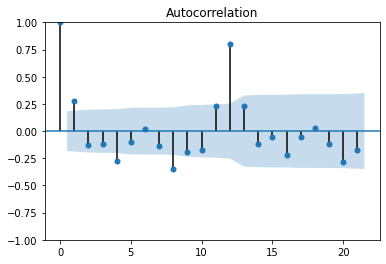

In [89]:
_ = plot_acf(train_data.Passengers.diff().dropna())

# **Using the auto_arima to find the parameters**

In [91]:
model = ARIMA(train_data, order=(12, 1, 1))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  115
Model:                ARIMA(12, 1, 1)   Log Likelihood                -424.153
Date:                Mon, 02 Jan 2023   AIC                            876.306
Time:                        19:36:04   BIC                            914.613
Sample:                    01-01-1949   HQIC                           891.853
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0904      0.088      1.023      0.306      -0.083       0.264
ar.L2         -0.0931      0.067     -1.382      0.167      -0.225       0.039
ar.L3          0.0494      0.057      0.865      0.387      -0.063       0.161
ar.L4         -0.0914      0.059     -1.540      0.124      -0.208       0.025
ar.L5          0.0613      0.062      0.983      0.326      -0.061       0.183
ar.L6         -0.0798      0.057     -1.411      0.158      -0.191       0.031
ar.L7          0.0122      0.068      0.179      0.858      -0.121       0.145
ar.L8         -0.1151      0.061     -1.891      0.059      -0.234       0.004
ar.L9          0.0412      0.068      0.602      0.547      -0.093       0.175
ar.L10        -0.1205      0.059     -2.057      0.040      -0.235      -0.006
ar.L11         0.0880      0.067      1.317      0.188      -0.043       0.219
ar.L12         0.8161      0.064     12.728      0.000       0.690       0.942
ma.L1         -0.2507      0.142     -1.761      0.078      -0.530       0.028
sigma2        82.5730     12.924      6.389      0.000      57.243     107.903
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 3.00
Prob(Q):                              0.72   Prob(JB):                         0.22
Heteroskedasticity (H):               1.86   Skew:                             0.40
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0, 0.5, 'Passengers')

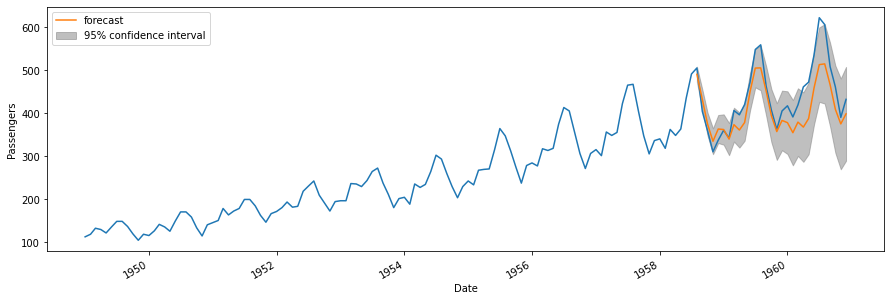

In [97]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(df)
plot_predict(model_fit, start=len(train_data), end=(len(df)-1), ax=axs)
plt.xlabel('Date')
plt.ylabel('Passengers')

Text(0, 0.5, 'Passengers')

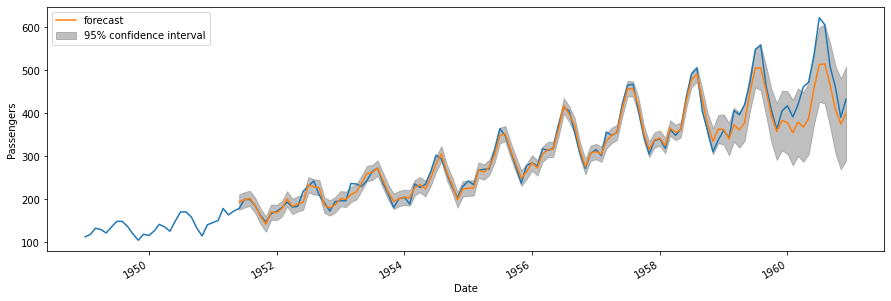

In [96]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(df)
plot_predict(model_fit, start=len(test_data), end=(len(df)-1), ax=axs)
plt.xlabel('Date')
plt.ylabel('Passengers')